In [1]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd
import geopandas as gpd
import random
from haversine import haversine

### 1. 산곡동

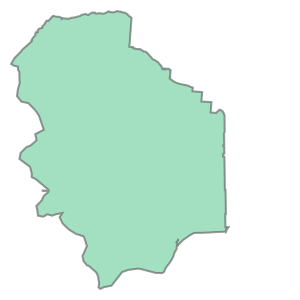

In [4]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][73]

In [5]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][73]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[174282.30913839 545074.27699336]
 [174060.5151798  544643.43571586]
 [174459.94568334 545144.38428618]
 [174847.74433031 543962.1529459 ]
 [174566.69741852 544835.65789317]
 [174463.29877095 545247.68963156]
 [173769.38191415 546043.54155911]
 [174520.36024321 544884.03252942]
 [174603.10314121 544749.4167678 ]
 [174024.14157975 544054.48842166]
 [174055.7787905  544853.33185537]
 [172834.19716375 545245.71135237]
 [173822.46088866 545100.15782542]
 [174640.65691821 543890.48668531]
 [174074.74245743 544155.20178196]
 [174738.45574553 544361.92747049]
 [173833.77869417 543720.65799379]
 [174424.75065519 544241.94706605]
 [174142.0380124  544617.3705027 ]
 [173079.30037427 544957.4167593 ]
 [173558.0450918  545980.43217854]
 [174639.3385383  543722.77509349]
 [173678.08419165 543445.6893091 ]
 [173160.29468861 544950.83663925]
 [173955.71247663 543361.28351859]
 [174349.01011838 544625.24681539]
 [174390.29078838 544595.7344022 ]
 [173777.24065771 545248.3412738

In [6]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

,경도,위도
0,174282.309138,545074.276993
1,174060.515180,544643.435716
2,174459.945683,545144.384286
3,174847.744330,543962.152946
4,174566.697419,544835.657893
...,...,...
195,173777.526703,546038.224033
196,173755.611893,545848.558769
197,174523.095835,543701.785435
198,174508.283045,544437.123024


In [7]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    174282.309138  545074.276993  37.504779  126.709141
1    174060.515180  544643.435716  37.500891  126.706648
2    174459.945683  545144.384286  37.505416  126.711148
3    174847.744330  543962.152946  37.494774  126.715574
4    174566.697419  544835.657893  37.502637  126.712366
..             ...            ...        ...         ...
195  173777.526703  546038.224033  37.513450  126.703398
196  173755.611893  545848.558769  37.511740  126.703157
197  174523.095835  543701.785435  37.492420  126.711912
198  174508.283045  544437.123024  37.499045  126.711719
199  173332.762646  545446.993301  37.508110  126.698389

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [10]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='산곡동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.48964621, 126.70800292],
       [ 37.49273242, 126.70822418],
       [ 37.50373793, 126.70738307],
       [ 37.50559436, 126.71108841],
       [ 37.5075316 , 126.70690534],
       [ 37.51276711, 126.70004091],
       [ 37.51196182, 126.69949481],
       [ 37.5010368 , 126.71426274],
       [ 37.50706974, 126.69897795],
       [ 37.51180801, 126.70101193],
       [ 37.51170286, 126.70187902],
       [ 37.5124881 , 126.70197784],
       [ 37.51370533, 126.69961881],
       [ 37.48893333, 126.70480935],
       [ 37.50337745, 126.70125825],
       [ 37.50396656, 126.69315794],
       [ 37.50441672, 126.69609685],
       [ 37.50358668, 126.69681451],
       [ 37.50414875, 126.69748846],
       [ 37.5031008 , 126.70471788],
       [ 37.50547355, 126.70668035],
       [ 37.50291649, 126.7148705 ],
       [ 37.50767595, 126.69833685],
       [ 37.50816368, 126.70291018],
       [ 37.49435831, 126.7064062 ],
       [ 37.49849934, 126.7032613 ],
       [ 37.49804618, 126.70670388],
 

In [11]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='산곡동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.50861507, 126.70334349]])

In [13]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='산곡동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.4876167, 126.7069167],
       [ 37.4877167, 126.7072667],
       [ 37.4881167, 126.7085667],
       [ 37.4896167, 126.7057333],
       [ 37.4897167, 126.7060667],
       [ 37.4917   , 126.7049833],
       [ 37.4910833, 126.7127   ],
       [ 37.49495  , 126.7029833],
       [ 37.4972167, 126.7025667],
       [ 37.4981167, 126.7022667],
       [ 37.4997167, 126.7024333],
       [ 37.5001333, 126.7029   ],
       [ 37.5045   , 126.6919167],
       [ 37.5044   , 126.6923167],
       [ 37.50185  , 126.7027167],
       [ 37.50195  , 126.7031167],
       [ 37.5047167, 126.69575  ],
       [ 37.5048833, 126.6964167],
       [ 37.5045333, 126.6986833],
       [ 37.5033667, 126.7029167],
       [ 37.5043167, 126.7018167],
       [ 37.5045333, 126.7017   ],
       [ 37.5042667, 126.7056167],
       [ 37.504    , 126.7062167],
       [ 37.5038   , 126.7095833],
       [ 37.5040167, 126.7098333],
       [ 37.5036667, 126.71155  ],
       [ 37.5038667, 126.7121167],
       [ 37.50345  ,

In [14]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 
m1= 0.311
m2= 0.088
m3= 0.601

In [15]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D3 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D3.append(site)
    D3 = np.array(D3)

    for i in [D1, D2, D3]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3 = {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m3*x3[c] for c in range(C)]), GRB.MAXIMIZE)


    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [16]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 4, 1000)
opts_sites

  K 4
  Radius 1000
Restricted license - for non-production use only - expires 2025-11-24
----- Output -----
  Running time : 0.2428734302520752 seconds
Optimal coverage points: 79.524


array([[ 37.4925704 , 126.70411685],
       [ 37.50192229, 126.71588014],
       [ 37.51236501, 126.7029208 ],
       [ 37.50535167, 126.6932688 ]])

In [13]:
pwd

'c:\\Users\\chldy\\OneDrive\\바탕 화면\\용용\\딥러닝 부트캠프\\교육데이터공모전'

In [17]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/산곡동_최종입지.csv')

### 2. 계산동

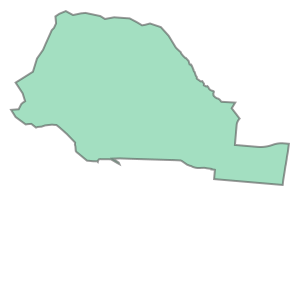

In [19]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][50]

In [20]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][50]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[174903.91524569 548736.94334052]
 [177034.0796864  548442.54984205]
 [174709.27409476 549346.47118721]
 [176197.77042382 549431.99077877]
 [174715.4961372  549527.74607931]
 [175129.03364632 548590.6209116 ]
 [175261.17475585 549447.32735012]
 [174741.23707881 548879.90857496]
 [176148.75752741 549042.8936482 ]
 [175232.34200863 548707.3386884 ]
 [174876.12458827 550278.2238417 ]
 [174545.32475406 549829.89348464]
 [174518.6225351  549074.48485165]
 [175876.99573291 549733.73129791]
 [175043.44235702 548833.14352949]
 [174682.85153668 550291.73703507]
 [176216.94147327 549109.43148594]
 [174868.88429101 548787.53149868]
 [175892.24631103 548822.34341754]
 [175333.19657515 548728.53966758]
 [174333.08667341 549610.22859154]
 [176688.57242315 549166.7410983 ]
 [174173.89331994 549079.15948963]
 [176307.62125368 549414.77039293]
 [174875.59776119 549639.42720689]
 [174339.65524411 549193.97278339]
 [175682.45023601 548640.68110707]
 [174984.73642039 549635.0799488

In [22]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

,경도,위도
0,174903.915246,548736.943341
1,177034.079686,548442.549842
2,174709.274095,549346.471187
3,176197.770424,549431.990779
4,174715.496137,549527.746079
...,...,...
195,175827.443847,549147.487303
196,174602.082726,549036.298523
197,176577.814174,548694.487281
198,175466.827847,549763.189200


In [23]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    174903.915246  548736.943341  37.537796  126.716046
1    177034.079686  548442.549842  37.535199  126.740157
2    174709.274095  549346.471187  37.543283  126.713823
3    176197.770424  549431.990779  37.544093  126.730663
4    174715.496137  549527.746079  37.544916  126.713887
..             ...            ...        ...         ...
195  175827.443847  549147.487303  37.541520  126.726482
196  174602.082726  549036.298523  37.540485  126.712621
197  176577.814174  548694.487281  37.537458  126.734987
198  175466.827847  549763.189200  37.547058  126.722381
199  176056.210170  548771.696117  37.538140  126.729083

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [24]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='계산동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.54302486, 126.72164599],
       [ 37.54426607, 126.7170731 ],
       [ 37.54232598, 126.73223411],
       [ 37.53662911, 126.72872494],
       [ 37.53972791, 126.72735942],
       [ 37.54049291, 126.7290386 ],
       [ 37.54095099, 126.72954347],
       [ 37.54208126, 126.72904937],
       [ 37.54229173, 126.71794987],
       [ 37.53897317, 126.71790262],
       [ 37.53767022, 126.72419384],
       [ 37.53765267, 126.73095399],
       [ 37.53680044, 126.73072237],
       [ 37.5374728 , 126.73290669],
       [ 37.5366475 , 126.73275292],
       [ 37.53673656, 126.74020198],
       [ 37.53673656, 126.74020198],
       [ 37.54472657, 126.71927744],
       [ 37.54536168, 126.71848102],
       [ 37.54084614, 126.72696767],
       [ 37.53512538, 126.74244284],
       [ 37.53645086, 126.74269643],
       [ 37.54484913, 126.72421032],
       [ 37.53985368, 126.72086655],
       [ 37.54419001, 126.72175602],
       [ 37.54501594, 126.72236688],
       [ 37.5447799 , 126.721606  ],
 

In [25]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='계산동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.53808356, 126.72260045],
       [ 37.54329002, 126.72808059]])

In [26]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='계산동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.5346   , 126.7339   ],
       [ 37.5343333, 126.7383667],
       [ 37.53385  , 126.7403833],
       [ 37.5342667, 126.7413333],
       [ 37.5401667, 126.7228833],
       [ 37.5356   , 126.7384667],
       [ 37.5357833, 126.73885  ],
       [ 37.5354833, 126.7414667],
       [ 37.5377   , 126.7342833],
       [ 37.5376833, 126.7346   ],
       [ 37.5444667, 126.71285  ],
       [ 37.5366333, 126.7386   ],
       [ 37.5447167, 126.7132167],
       [ 37.5439667, 126.71675  ],
       [ 37.5435833, 126.7173833],
       [ 37.53575  , 126.74125  ],
       [ 37.5378667, 126.7361167],
       [ 37.5382   , 126.7361   ],
       [ 37.5422   , 126.7228667],
       [ 37.5378   , 126.7375833],
       [ 37.53675  , 126.7416333],
       [ 37.54245  , 126.7224   ],
       [ 37.5425   , 126.72295  ],
       [ 37.5434333, 126.72035  ],
       [ 37.5438167, 126.7206833],
       [ 37.5376167, 126.7402833],
       [ 37.53685  , 126.7441   ],
       [ 37.5405833, 126.7353667],
       [ 37.5429667,

In [27]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 4, 1000)
opts_sites

  K 4
  Radius 1000
----- Output -----
  Running time : 0.11478304862976074 seconds
Optimal coverage points: 68.685


array([[ 37.5364842 , 126.71859851],
       [ 37.53543077, 126.74374896],
       [ 37.54554483, 126.72114722],
       [ 37.53704191, 126.7410842 ]])

In [28]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/계산동_최종입지.csv')

### 3. 부개동

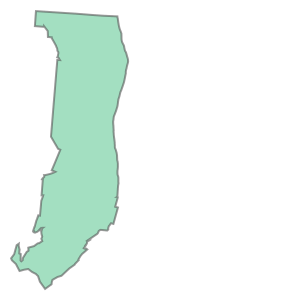

In [29]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][66]

In [30]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][66]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[176326.54397454 542726.97238684]
 [176973.09504032 544235.69118122]
 [176851.77364956 543797.34341291]
 [177070.26230682 544307.01994416]
 [176417.92890417 542501.6362734 ]
 [176071.13679089 542306.13632286]
 [177128.65555189 543992.91465188]
 [177072.09644719 544412.12516497]
 [176692.52362801 545221.84311579]
 [176471.57048106 543820.96168802]
 [177103.30909706 544042.13211305]
 [177148.56949786 543905.17095875]
 [176831.87727468 543198.1349676 ]
 [176459.86606876 542681.38130898]
 [176849.18284257 544010.8965452 ]
 [176721.5578499  544262.0229316 ]
 [177122.15077081 544566.05531132]
 [176383.18383701 542875.12039704]
 [177169.11143003 543031.2758506 ]
 [176859.55597654 543300.6030435 ]
 [176312.32345183 542804.87800274]
 [176727.74869438 542858.48825616]
 [176760.28048163 544971.35005749]
 [177051.01061128 543388.85967924]
 [177301.81575889 544848.11051953]
 [176896.36667406 543770.82406897]
 [176576.92229527 545157.6341888 ]
 [176642.58373453 542578.7288283

In [31]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

,경도,위도
0,176326.543975,542726.972387
1,176973.095040,544235.691181
2,176851.773650,543797.343413
3,177070.262307,544307.019944
4,176417.928904,542501.636273
...,...,...
195,177107.146170,543642.422341
196,176945.257073,543677.343345
197,176713.592757,543260.527391
198,177173.256924,544858.913787


In [32]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    176326.543975  542726.972387  37.483685  126.732336
1    176973.095040  544235.691181  37.497294  126.739599
2    176851.773650  543797.343413  37.493342  126.738241
3    177070.262307  544307.019944  37.497939  126.740696
4    176417.928904  542501.636273  37.481657  126.733377
..             ...            ...        ...         ...
195  177107.146170  543642.422341  37.491952  126.741134
196  176945.257073  543677.343345  37.492263  126.739302
197  176713.592757  543260.527391  37.488502  126.736696
198  177173.256924  544858.913787  37.502915  126.741843
199  176522.583754  545092.534655  37.505003  126.734477

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [33]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='부개동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4901405 , 126.73753766],
       [ 37.48649926, 126.73523951],
       [ 37.50580065, 126.73380202],
       [ 37.50606418, 126.7348697 ],
       [ 37.49814198, 126.73622601],
       [ 37.50510535, 126.73848792],
       [ 37.50224036, 126.73866169],
       [ 37.50519712, 126.74126619],
       [ 37.48984457, 126.73387845],
       [ 37.49519664, 126.73613712],
       [ 37.4958269 , 126.73774744],
       [ 37.48253138, 126.73822473],
       [ 37.49936172, 126.73840261],
       [ 37.49938884, 126.74131414],
       [ 37.50230104, 126.74117252],
       [ 37.49311146, 126.74106024],
       [ 37.49650783, 126.7417694 ],
       [ 37.50632021, 126.732338  ],
       [ 37.4942932 , 126.73519576],
       [ 37.49610218, 126.7353061 ],
       [ 37.49676645, 126.73530322],
       [ 37.50332661, 126.73599481],
       [ 37.50366378, 126.73666795],
       [ 37.5056484 , 126.73589625],
       [ 37.48575218, 126.73410679],
       [ 37.48593345, 126.73593691],
       [ 37.48761534, 126.74129479],
 

In [35]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='부개동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([], dtype=float64)

In [36]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='부개동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.48495  , 126.7343667],
       [ 37.4850833, 126.7346167],
       [ 37.4859   , 126.7372167],
       [ 37.48585  , 126.7377333],
       [ 37.4868167, 126.7345167],
       [ 37.4870833, 126.7343   ],
       [ 37.4866333, 126.7371   ],
       [ 37.4868833, 126.7382833],
       [ 37.48695  , 126.7392333],
       [ 37.48715  , 126.7395667],
       [ 37.4899167, 126.7342333],
       [ 37.48915  , 126.7398833],
       [ 37.49195  , 126.7407667],
       [ 37.4921167, 126.74055  ],
       [ 37.49355  , 126.73485  ],
       [ 37.49375  , 126.7345333],
       [ 37.4941167, 126.7352833],
       [ 37.4940833, 126.7354667],
       [ 37.4935   , 126.7379667],
       [ 37.4933833, 126.7396   ],
       [ 37.4950667, 126.7355833],
       [ 37.4951833, 126.7354   ],
       [ 37.4935333, 126.7414167],
       [ 37.4937167, 126.7412667],
       [ 37.4962   , 126.7367333],
       [ 37.4966   , 126.7357333],
       [ 37.4962   , 126.7370333],
       [ 37.49665  , 126.7355333],
       [ 37.4975667,

In [37]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 5, 1000)
opts_sites

  K 5
  Radius 1000
----- Output -----
  Running time : 0.12759637832641602 seconds
Optimal coverage points: 80.184


array([[ 37.48485879, 126.73806834],
       [ 37.48898726, 126.73812313],
       [ 37.4800073 , 126.73247563],
       [ 37.49407272, 126.73980826],
       [ 37.50271865, 126.7385292 ]])

In [38]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/부개동_최종입지.csv')

### 1. 부평동

In [39]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][70]  # 대상 폴리곤 추출
    
    #제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths ,M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[175689.48484691 541312.4208287 ]
 [174839.23751845 542139.31874853]
 [175915.91823271 544031.29117912]
 [174707.65979951 543316.43661707]
 [175713.88561909 543481.59172833]
 [176077.72775935 544120.73929463]
 [174991.41790529 541856.74142808]
 [176174.96815402 543726.84312557]
 [176080.78209437 544252.54396281]
 [175448.69167537 545267.95123766]
 [175080.74549962 543511.20965683]
 [176132.75951725 543788.56309617]
 [176208.13020835 543616.8102626 ]
 [175841.48752898 541399.25608368]
 [174729.26682614 542415.41266771]
 [175680.75282534 542730.16882373]
 [175061.25451792 542082.1463565 ]
 [175709.57123147 543749.39288536]
 [174578.77905045 542791.17763616]
 [175497.04143213 544064.31187585]
 [176164.13595111 544445.57635177]
 [174933.55806141 542325.10018905]
 [176242.33802793 542520.92317085]
 [175726.84527815 542858.66644393]
 [174815.55653892 542237.01440793]
 [175507.35084652 542304.24305376]
 [175561.52498648 544953.82645701]
 [175129.4323608  542123.0896071

In [40]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])
sites_df

,경도,위도
0,175689.484847,541312.420829
1,174839.237518,542139.318749
2,175915.918233,544031.291179
3,174707.659800,543316.436617
4,175713.885619,543481.591728
...,...,...
195,174650.446446,542157.143471
196,175443.808081,542352.512361
197,176470.831455,543516.709803
198,175824.794092,541734.917881


In [41]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    175689.484847  541312.420829  37.470923  126.725180
1    174839.237518  542139.318749  37.478351  126.715540
2    175915.918233  544031.291179  37.495426  126.727651
3    174707.659800  543316.436617  37.488953  126.714012
4    175713.885619  543481.591728  37.490468  126.725384
..             ...            ...        ...         ...
195  174650.446446  542157.143471  37.478506  126.713405
196  175443.808081  542352.512361  37.480288  126.722368
197  176470.831455  543516.709803  37.490804  126.733942
198  175824.794092  541734.917881  37.474733  126.726696
199  176223.889985  543256.039714  37.488449  126.731159

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

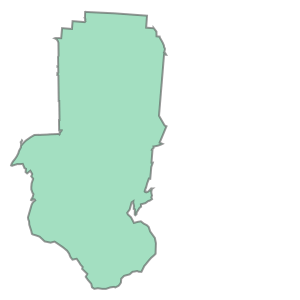

In [37]:
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][70]

In [42]:
# 아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='부평동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.49641145, 126.72984233],
       [ 37.49091882, 126.71850116],
       [ 37.49081395, 126.71892222],
       [ 37.4914431 , 126.72748851],
       [ 37.49087875, 126.72752891],
       [ 37.49079964, 126.72840547],
       [ 37.50095247, 126.72159699],
       [ 37.5011451 , 126.72237192],
       [ 37.50179182, 126.72218726],
       [ 37.50253875, 126.7220125 ],
       [ 37.50286994, 126.72206628],
       [ 37.50321458, 126.72200652],
       [ 37.50430416, 126.72192006],
       [ 37.50492669, 126.72100499],
       [ 37.49053562, 126.73067746],
       [ 37.49071793, 126.73147446],
       [ 37.49023988, 126.73146194],
       [ 37.49014941, 126.73176231],
       [ 37.49007419, 126.73198693],
       [ 37.49023942, 126.73272792],
       [ 37.48979858, 126.73278954],
       [ 37.49015718, 126.73297206],
       [ 37.49011293, 126.73339555],
       [ 37.48381954, 126.71617309],
       [ 37.48453593, 126.71740435],
       [ 37.48642931, 126.7198176 ],
       [ 37.48718189, 126.72296349],
 

In [43]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='부평동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.48519431, 126.71795245],
       [ 37.49044727, 126.72348637],
       [ 37.49841586, 126.72226437]])

In [44]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='부평동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points


array([[ 37.4829667, 126.7143167],
       [ 37.4847833, 126.7174   ],
       [ 37.4850833, 126.7172833],
       [ 37.485    , 126.7198333],
       [ 37.4852167, 126.7195167],
       [ 37.4847833, 126.7210333],
       [ 37.485    , 126.7215667],
       [ 37.4851333, 126.7242333],
       [ 37.4853167, 126.7240333],
       [ 37.49065  , 126.712    ],
       [ 37.4852   , 126.7301   ],
       [ 37.4853667, 126.7299   ],
       [ 37.4912333, 126.7172833],
       [ 37.487    , 126.73055  ],
       [ 37.4873333, 126.7312   ],
       [ 37.48805  , 126.7295333],
       [ 37.4911   , 126.7203667],
       [ 37.4911333, 126.72155  ],
       [ 37.4913667, 126.7213833],
       [ 37.49115  , 126.72505  ],
       [ 37.4920667, 126.7244667],
       [ 37.4926   , 126.7232167],
       [ 37.49095  , 126.72845  ],
       [ 37.4912333, 126.7283333],
       [ 37.4931167, 126.72275  ],
       [ 37.4924667, 126.7248667],
       [ 37.4904167, 126.7317833],
       [ 37.4926333, 126.7246333],
       [ 37.4931   ,

In [8]:
# 가중치 도보+자전거 0.601  버스 0.311, 0.088 지하철 
m1= 0.311
m2= 0.088
m3= 0.601

In [9]:
def mclp(버스_points, 지하철_points,주택_points, K, radius):

    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(sites_df['latitude'], sites_df['longitude'])])
    J = sites.shape[0]                             
    
    # 수요지점 수
    A = 버스_points.shape[0]
    B = 지하철_points.shape[0]
    C = 주택_points.shape[0]
    
    # 입지후보지와 수요지점 간 거리 계산
    D1 = []
    for i in 버스_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D1.append(site)
    D1 = np.array(D1)
    
    D2 = []
    for i in 지하철_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D2.append(site)
    D2 = np.array(D2)    
    

    
    D3 = []
    for i in 주택_points:
        site = []
        for j in sites:
            site.append(haversine(i, j, unit='m'))
        D3.append(site)
    D3 = np.array(D3)

    for i in [D1, D2, D3]:
        mask1 = i<=radius
        i[mask1]=1                                                 
        i[~mask1]=0

    m = Model()
    x1, x2, x3 = {}, {}, {}
    y = {}
    
    # 수요지점 변수 추가
    for i in range(A):                                       
        x1[i] = m.addVar(vtype=GRB.BINARY, name="x1%d" % i)
    for i in range(B):                                       
        x2[i] = m.addVar(vtype=GRB.BINARY, name="x2%d" % i)
    
    for i in range(C):                                       
        x3[i] = m.addVar(vtype=GRB.BINARY, name="x3%d" % i)
    
    # 입지후보지 변수 추가
    for j in range(J):
        y[j] = m.addVar(vtype=GRB.BINARY, name="y%d" % j)

    m.update()
    m.addConstr(quicksum(y[j] for j in range(J)) == K) 

    # 수요지점 제약 조건
    for i in range(A): 
        m.addConstr(quicksum(y[j] for j in np.where(D1[i]==1)[0]) >= x1[i])
    for i in range(B): 
        m.addConstr(quicksum(y[j] for j in np.where(D2[i]==1)[0]) >= x2[i])
    
    for i in range(C): 
        m.addConstr(quicksum(y[j] for j in np.where(D3[i]==1)[0]) >= x3[i])
    
    # 목적함수 수정
    m.setObjective(quicksum(i for i in [m1*x1[a] for a in range(A)] + [m2*x2[b] for b in range(B)]  + [m3*x3[c] for c in range(C)]), GRB.MAXIMIZE)


    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x==1 and v.varName[0]=="y":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [45]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 4, 1000)
opts_sites

  K 4
  Radius 1000
----- Output -----
  Running time : 0.3315441608428955 seconds
Optimal coverage points: 238.914


array([[ 37.48781846, 126.71470799],
       [ 37.49542382, 126.71644992],
       [ 37.50628065, 126.72754087],
       [ 37.49080375, 126.7339424 ]])

In [46]:
df= pd.DataFrame(data=opts_sites, columns= ['위도','경도'])
df.to_csv('교육 공모전 자료/부평동_최종_입지.csv')

In [12]:
pwd

'c:\\Users\\chldy\\OneDrive\\바탕 화면\\용용\\딥러닝 부트캠프\\교육데이터공모전'

### 만수동

In [47]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][2]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[175881.9276196  539350.88744238]
 [175886.63385059 539723.23201156]
 [176299.37446592 539558.04930629]
 [176970.72468336 538727.3292283 ]
 [176008.13006369 541264.73793043]
 [175757.91955065 540343.8526842 ]
 [176765.1693868  540146.33240118]
 [175861.94211438 541292.49447247]
 [177022.29768405 538864.00012763]
 [176776.70462528 538274.31182658]
 [176837.32025293 541092.42585867]
 [175597.38682496 539892.65379483]
 [176007.73158201 539952.62870765]
 [176495.67374374 541340.88977811]
 [176618.0189848  537901.17148736]
 [176090.2819254  539943.69929727]
 [176900.98094881 537786.63042485]
 [175491.81761982 540483.52169627]
 [176551.95768388 539548.12265942]
 [176003.11434105 540979.7607963 ]
 [176719.08040361 540347.4215625 ]
 [176454.884634   539405.11500828]
 [176193.77340154 539718.98556661]
 [175496.46620661 539908.8810172 ]
 [175908.82811586 541126.13741311]
 [175932.4888007  540076.94700936]
 [176545.14014107 540590.09604722]
 [176416.97297393 539180.7988844

In [48]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [49]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    175881.927620  539350.887442  37.453255  126.727420
1    175886.633851  539723.232012  37.456609  126.727461
2    176299.374466  539558.049306  37.455132  126.732131
3    176970.724683  538727.329228  37.447664  126.739745
4    176008.130064  541264.737930  37.470502  126.728784
..             ...            ...        ...         ...
195  176588.676758  538919.396647  37.449385  126.735421
196  176278.477065  539075.891565  37.450787  126.731910
197  175570.510617  540151.062741  37.460456  126.723874
198  176247.523905  538875.127998  37.448977  126.731567
199  175639.875868  539613.682606  37.455616  126.724675

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [50]:
#아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='만수동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.44921966, 126.73295724],
       [ 37.45169949, 126.72648214],
       [ 37.45167541, 126.72677636],
       [ 37.45164405, 126.72707508],
       [ 37.45198231, 126.72749947],
       [ 37.46429623, 126.72313986],
       [ 37.43847555, 126.73717716],
       [ 37.45753859, 126.72485995],
       [ 37.44053721, 126.73959107],
       [ 37.44984664, 126.7392879 ],
       [ 37.4498875 , 126.73915775],
       [ 37.45843344, 126.73199056],
       [ 37.46253137, 126.73677108],
       [ 37.46386839, 126.73693583],
       [ 37.46358827, 126.73752636],
       [ 37.46395892, 126.7381234 ],
       [ 37.4644785 , 126.73833264],
       [ 37.46500354, 126.73853845],
       [ 37.46041175, 126.72832213],
       [ 37.46064217, 126.73010409],
       [ 37.46317302, 126.73127027],
       [ 37.46190307, 126.73758886],
       [ 37.46253751, 126.72409277],
       [ 37.46336014, 126.72453225],
       [ 37.45034383, 126.73391319],
       [ 37.44247487, 126.73497372],
       [ 37.44273797, 126.73494006],
 

In [51]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='만수동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.44817192, 126.73663642],
       [ 37.45496238, 126.73190368]])

In [52]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='만수동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4394167, 126.7368   ],
       [ 37.4397   , 126.73785  ],
       [ 37.4422167, 126.73855  ],
       [ 37.4422833, 126.7388833],
       [ 37.4433167, 126.7362833],
       [ 37.4435333, 126.7366   ],
       [ 37.4457333, 126.7327833],
       [ 37.4445   , 126.7389167],
       [ 37.4446167, 126.7386333],
       [ 37.44675  , 126.7328167],
       [ 37.4483   , 126.7306667],
       [ 37.4486333, 126.7305   ],
       [ 37.4491667, 126.7294833],
       [ 37.4481667, 126.7331833],
       [ 37.44585  , 126.74055  ],
       [ 37.4485   , 126.7329   ],
       [ 37.4460167, 126.7407667],
       [ 37.4495833, 126.7297   ],
       [ 37.44805  , 126.7348   ],
       [ 37.4483833, 126.7349833],
       [ 37.4472167, 126.73985  ],
       [ 37.4504833, 126.7296167],
       [ 37.45045  , 126.7297833],
       [ 37.4474333, 126.7397333],
       [ 37.4490833, 126.7343667],
       [ 37.4479333, 126.7381833],
       [ 37.4482667, 126.7382667],
       [ 37.4517333, 126.72715  ],
       [ 37.4518667,

In [53]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 6, 1000)
opts_sites


  K 6
  Radius 1000
----- Output -----
  Running time : 0.17955851554870605 seconds
Optimal coverage points: 111.948


array([[ 37.44526792, 126.73457858],
       [ 37.43860363, 126.7369577 ],
       [ 37.45873452, 126.72174793],
       [ 37.45049346, 126.74184805],
       [ 37.47184598, 126.73044041],
       [ 37.46285353, 126.74117082]])

In [54]:
df= pd.DataFrame(data= opts_sites, columns=['위도','경도'])
df.to_csv('교육 공모전 자료/만수동_최종입지.csv')

### 효성동

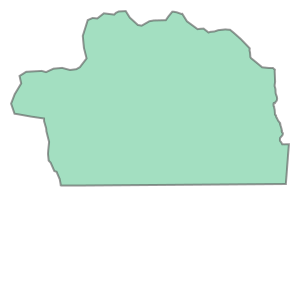

In [55]:
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][94]

In [57]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][94]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/shp_file/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[174030.99377618 547214.75006706]
 [172837.71614267 547622.37487092]
 [174348.78118429 548555.03520595]
 [174858.67300787 547342.11345041]
 [173318.7390529  547224.59407162]
 [172653.05369939 548202.64291706]
 [174065.23898309 548284.05722253]
 [172658.95675511 548375.21588157]
 [174575.87238772 548599.12924666]
 [173051.29335227 547483.07651007]
 [175071.63558471 547855.56385203]
 [174712.34419321 548404.95552242]
 [174580.15898708 548664.10323042]
 [173176.65995655 548298.65757645]
 [174653.1065802  548435.38079053]
 [174758.88540115 548350.71409417]
 [174244.32158644 547257.55608087]
 [172683.37803061 547758.4771962 ]
 [174018.73884084 547913.63832708]
 [173149.30538367 547594.19136177]
 [174059.18396583 548416.0715758 ]
 [172472.17631218 547943.71302506]
 [173760.90951378 548571.31297701]
 [174697.14176326 548759.25982448]
 [172687.14322191 547229.33054981]
 [172970.09008909 547713.95706195]
 [174806.89428588 547810.48929723]
 [174083.42718643 547976.9820796

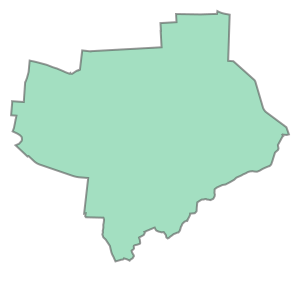

In [104]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][43]

In [58]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [59]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    174030.993776  547214.750067  37.524057  126.706224
1    172837.716143  547622.374871  37.527696  126.692710
2    174348.781184  548555.035206  37.536142  126.709772
3    174858.673008  547342.113450  37.525228  126.715582
4    173318.739053  547224.594072  37.524126  126.698166
..             ...            ...        ...         ...
195  174066.089266  548770.022474  37.538071  126.706566
196  174071.363308  548714.493676  37.537571  126.706627
197  175046.743787  547573.324038  37.527316  126.717702
198  173783.897093  547611.585364  37.527626  126.703414
199  174227.598343  548740.540727  37.537810  126.708394

[200 rows x 4 columns]


C:\Users\chldy\AppData\Local\Temp\ipykernel_1928\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(proj_UTM, proj_WGS84, x, y)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_

In [60]:
#아파트 좌표
apt= pd.read_csv('교육 공모전 자료/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='효성동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.52785738, 126.69784472],
       [ 37.52464485, 126.71705875],
       [ 37.52476271, 126.7157624 ],
       [ 37.52509835, 126.71581447],
       [ 37.52757259, 126.7171462 ],
       [ 37.53128958, 126.7167564 ],
       [ 37.5299245 , 126.71193541],
       [ 37.53300647, 126.71124885],
       [ 37.53523249, 126.71010858],
       [ 37.53492555, 126.7113208 ],
       [ 37.53414247, 126.71135842],
       [ 37.53414681, 126.71259378],
       [ 37.5329796 , 126.71317179],
       [ 37.53482912, 126.7138746 ],
       [ 37.52564367, 126.69841568],
       [ 37.52631589, 126.71454893],
       [ 37.52556735, 126.69734184],
       [ 37.52757754, 126.70850704],
       [ 37.52834907, 126.70854327],
       [ 37.52710101, 126.71311301],
       [ 37.53440805, 126.70617627],
       [ 37.53321918, 126.71491592],
       [ 37.528756  , 126.69976964],
       [ 37.52897304, 126.70080116],
       [ 37.52913156, 126.69875104],
       [ 37.53126688, 126.70048672],
       [ 37.53132675, 126.70960711],
 

In [61]:
# 지하철 좌표
train= pd.read_csv('교육 공모전 자료/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='효성동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([], dtype=float64)

In [62]:
#버스 정류장 좌표
bus= pd.read_csv('교육 공모전 자료/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='효성동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.5307   , 126.71145  ],
       [ 37.5301167, 126.71155  ],
       [ 37.5266667, 126.6981   ],
       [ 37.5272333, 126.6987333],
       [ 37.5302667, 126.71065  ],
       [ 37.5304833, 126.7116667],
       [ 37.5284833, 126.7026333],
       [ 37.5283333, 126.70145  ],
       [ 37.5241667, 126.69325  ],
       [ 37.52445  , 126.6930167],
       [ 37.52585  , 126.6976   ],
       [ 37.5260833, 126.69755  ],
       [ 37.5267833, 126.7      ],
       [ 37.5272333, 126.7006333],
       [ 37.5277   , 126.70585  ],
       [ 37.5278667, 126.70585  ],
       [ 37.5277167, 126.7086167],
       [ 37.5278833, 126.70885  ],
       [ 37.5277667, 126.7135833],
       [ 37.52795  , 126.7137167],
       [ 37.5277833, 126.7158333],
       [ 37.528    , 126.7178667],
       [ 37.526531 , 126.697496 ],
       [ 37.527226 , 126.698651 ],
       [ 37.530301 , 126.709979 ],
       [ 37.530441 , 126.712105 ],
       [ 37.52851  , 126.702658 ],
       [ 37.527787 , 126.700922 ],
       [ 37.528354 ,

In [63]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 3, 1000)
opts_sites

  K 3
  Radius 1000
----- Output -----
  Running time : 0.09803915023803711 seconds
Optimal coverage points: 56.695


array([[ 37.52763561, 126.69731738],
       [ 37.52544881, 126.71898909],
       [ 37.53962005, 126.71219495]])

In [64]:
df= pd.DataFrame(data= opts_sites, columns= ['위도','경도'])
df.to_csv('교육 공모전 자료/효성동_최종입지.csv')

### 간석동

In [29]:
#랜덤 좌표 생성
def generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M=100):
    # 대상 .shp 파일에서 폴리곤 불러오기
    random.seed(42)
    gdf = gpd.read_file(shp_file_path)
    poly = gdf['geometry'][49]  # 대상 폴리곤 추출
    
    # 제외할 .shp 파일들에서 폴리곤들 불러오기
    ex_poligon_list=[]
    for ex_path in exclusion_shp_paths:
        ex= gpd.read_file(ex_path)
        for ex_poly in ex['geometry']:
            ex_poligon_list.append(ex_poly)
    
    

    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    attempts = 0  # 시도 횟수
    while len(sites) < M:
        random_point = Point(random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y))
        
        # 진행도 체크
        if attempts % 1000 == 0:  # 100번의 시도마다 진행 상황 출력
            print(f"시도 횟수: {attempts}, 유효한 사이트 수: {len(sites)}")

        # 대상 폴리곤 내에 있고 제외할 폴리곤들 내에 없는지 확인
        if random_point.within(poly) :
            if not any(random_point.within(ex_poly) for ex_poly in ex_poligon_list):
                sites.append(random_point)
        attempts += 1  # 시도 횟수 증가

    return np.array([(p.x, p.y) for p in sites])

# 사용 예시
path= 'C:/Users/chldy/OneDrive/바탕 화면/용용/딥러닝 부트캠프/교육데이터공모전/교육 공모전 자료/'
shp_file_path = path+'행정구역_읍면동.shp'
exclusion_shp_paths = [path+'상습침수구역.shp', path+'개발제한구역.shp', path+'공항_소음대책지역.shp']  # 제외할 .shp 파일들의 경로 리스트
M = 200  # 생성할 좌표 수
sites = generate_candidate_sites_from_shp(shp_file_path, exclusion_shp_paths, M)
print(sites)



시도 횟수: 0, 유효한 사이트 수: 0
[[174640.89636526 541392.86611642]
 [173545.80736929 539560.18112326]
 [172838.08417702 540907.44512117]
 [174339.44855554 541019.59346957]
 [172844.36000901 541145.16468208]
 [174882.32831292 541453.60573474]
 [173261.47254953 539916.24113502]
 [175027.4182737  541186.13108946]
 [174886.8856098  541543.1075112 ]
 [173394.75601884 541039.70548268]
 [174964.43982246 541228.04194958]
 [175076.89854555 541111.41342703]
 [174290.01194267 540509.3407922 ]
 [173365.67401255 540069.30203789]
 [174333.01116568 541201.44347246]
 [175011.25581467 541674.18588621]
 [175127.93917756 540367.25282289]
 [174358.78533869 540596.59692232]
 [175260.86093285 540775.70010709]
 [174031.28318706 540220.116491  ]
 [173467.4004667  540097.10449528]
 [172458.64461574 541253.33027724]
 [174834.49353772 540671.75137823]
 [175544.85626683 540974.75492879]
 [174450.24904572 540997.01106715]
 [175126.14732201 540221.95070571]
 [173819.67342515 539981.88887889]
 [174197.00759132 539908.7613155

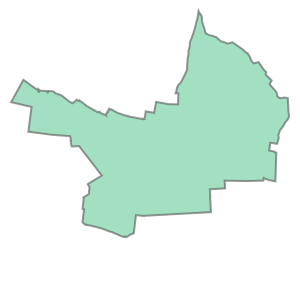

In [116]:
path= 'C:/Users/USER/Desktop/용용/딥러닝부트캠프/교육공공데이터공모전/교육 공모전 자료/'
ex= path+'행정구역_읍면동.shp'
gpff= gpd.read_file(ex)
gpff['geometry'][49]

In [30]:
sites_df= pd.DataFrame(data=sites, columns=['경도','위도'])

In [31]:
from pyproj import Proj, transform

# 좌표 변환 함수 정의
def convert_coords(x, y):
    proj_UTM = Proj(init='epsg:5186')  # 원본 좌표계
    proj_WGS84 = Proj(init='epsg:4326')  # 목표 좌표계
    lon, lat = transform(proj_UTM, proj_WGS84, x, y)
    return pd.Series([lat, lon])

    # 새로운 'latitude'와 'longitude' 컬럼을 생성하고 변환된 좌표를 적용
sites_df[['latitude', 'longitude']] = sites_df.apply(lambda row: convert_coords(row['경도'], row['위도']), axis=1)

print(sites_df)

c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_6436\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

                경도             위도   latitude   longitude
0    174640.896365  541392.866116  37.471620  126.713324
1    173545.807369  539560.181123  37.455076  126.701010
2    172838.084177  540907.445121  37.467195  126.692962
3    174339.448556  541019.593470  37.468248  126.709929
4    172844.360009  541145.164682  37.469337  126.693024
..             ...            ...        ...         ...
195  174417.629320  541131.833660  37.469262  126.710809
196  173128.967250  540632.474119  37.464726  126.696260
197  173136.537356  540871.378922  37.466878  126.696337
198  174411.172692  541581.093549  37.473309  126.710720
199  175370.270808  540663.158234  37.465065  126.721593

[200 rows x 4 columns]


c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\chldy\anaconda3\envs\mclp\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\chldy\AppData\Local\Temp\ipykernel_6436\519013629.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj

In [32]:
#아파트 좌표
apt= pd.read_csv('data/인천_아파트.csv')
apt.drop(['Unnamed: 0'], axis=1, inplace=True)
apt= apt[apt['legal_dong']=='간석동']
apt_points= np.array([list(i) for i in zip (apt['la'],apt['lo'])])
apt_points

array([[ 37.4644432 , 126.71549018],
       [ 37.46748368, 126.69107789],
       [ 37.4590903 , 126.71063339],
       [ 37.4648583 , 126.70561062],
       [ 37.46574995, 126.7062016 ],
       [ 37.46595872, 126.70649677],
       [ 37.46771823, 126.70750814],
       [ 37.45820194, 126.69780422],
       [ 37.45783225, 126.69960336],
       [ 37.45570854, 126.69969079],
       [ 37.45697012, 126.7028436 ],
       [ 37.4569756 , 126.70305454],
       [ 37.46336308, 126.69925968],
       [ 37.46091579, 126.70276318],
       [ 37.46661897, 126.69215269],
       [ 37.46775777, 126.69338287],
       [ 37.46702692, 126.69435576],
       [ 37.46762166, 126.68940604],
       [ 37.46219386, 126.69744916],
       [ 37.45893423, 126.70711027],
       [ 37.46514812, 126.69492   ],
       [ 37.46702432, 126.69868313],
       [ 37.46802921, 126.70844893],
       [ 37.46800508, 126.70966971],
       [ 37.46602641, 126.71515183],
       [ 37.46117063, 126.70991055],
       [ 37.46352297, 126.70927141],
 

In [33]:
# 지하철 좌표
train= pd.read_csv('data/인천_지하철역.csv')
train.drop(['Unnamed: 0'],axis=1)
train= train[train['legal_dong']=='간석동']
train_points= np.array([list(i) for i in zip (train['lon'],train['lat'])])
train_points


array([[ 37.46664592, 126.70816108],
       [ 37.4574194 , 126.70234212],
       [ 37.45688086, 126.70130161]])

In [34]:
#버스 정류장 좌표
bus= pd.read_csv('data/인천_버스정류장.csv')
bus.drop(['Unnamed: 0'],axis=1, inplace=True)
bus= bus[bus['legal_dong']=='간석동']
bus_points= np.array([list(i) for i in zip (bus['위도'],bus['경도'])])
bus_points

array([[ 37.4572833, 126.6949833],
       [ 37.4575833, 126.6948   ],
       [ 37.4570833, 126.697    ],
       [ 37.45735  , 126.6972   ],
       [ 37.4569333, 126.69875  ],
       [ 37.4572   , 126.6991333],
       [ 37.4568833, 126.7047667],
       [ 37.4674167, 126.6904   ],
       [ 37.4675667, 126.6899833],
       [ 37.4614667, 126.7189333],
       [ 37.4619167, 126.7186667],
       [ 37.4615167, 126.7204333],
       [ 37.4636667, 126.7152333],
       [ 37.46395  , 126.7138167],
       [ 37.4622667, 126.7201667],
       [ 37.46535  , 126.71105  ],
       [ 37.4625167, 126.7206167],
       [ 37.4657167, 126.7110667],
       [ 37.4671667, 126.7064167],
       [ 37.4674833, 126.7065167],
       [ 37.4641667, 126.7205   ],
       [ 37.46365  , 126.7208333],
       [ 37.4695833, 126.7081667],
       [ 37.4741333, 126.7094167],
       [ 37.4763   , 126.7099333],
       [ 37.4759   , 126.7136   ],
       [ 37.47665  , 126.71255  ],
       [ 37.4680667, 126.72085  ],
       [ 37.4734833,

In [35]:
opts_sites, mobjVal = mclp(bus_points, train_points,apt_points, 4, 1000)
opts_sites

  K 4
  Radius 1000
----- Output -----
  Running time : 0.15846014022827148 seconds
Optimal coverage points: 113.268


array([[ 37.46719473, 126.69296158],
       [ 37.47359051, 126.70998186],
       [ 37.46714068, 126.72145579],
       [ 37.45731811, 126.70255632]])

In [36]:
df= pd.DataFrame(data= opts_sites, columns= ['위도','경도'])
df.to_csv('간석동_최종입지.csv')